In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import rankdata, zscore
import os
import joblib
from pygeneconverter import ensembl_to_hugo

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Data Loading for Model Training

In [4]:
meta_neg = pd.read_csv('meta_neg_sep_hallmark.csv', index_col=(0))
meta_neg['sample'] = meta_neg.index.str.split('&').str[0]
meta_neg.index = [f'Negative_{j+1}' for j in range(len(meta_neg.index))]
meta_neg['Class'] = 0
meta_neg

,Cancer,Hallmark,sample,Class
Negative_1,Ovarian,AID,1,0
Negative_2,Breast,AID,1,0
Negative_3,Ovarian,AID,1,0
Negative_4,Prostate,AIM,1,0
Negative_5,Prostate,AIM,1,0
...,...,...,...,...
Negative_39139,Hematologic,ERI,tFL1,0
Negative_39140,Hematologic,IA,tFL1,0
Negative_39141,Hematologic,IA,tFL1,0
Negative_39142,Hematologic,ERI,tFL2,0


In [5]:
meta_pos = pd.read_csv('meta_pos_sep_hallmark.csv', index_col=(0))
meta_pos['sample'] = meta_pos.index.str.split('&').str[0]
meta_pos.index = [f'Positive_{j+1}' for j in range(len(meta_pos.index))]
meta_pos['Class'] = 1
meta_pos

,Cancer,Hallmark,sample,Class
Positive_1,Ovarian,AIM,1,1
Positive_2,Ovarian,AIM,1,1
Positive_3,Ovarian,AIM,1,1
Positive_4,Ovarian,AIM,1,1
Positive_5,Ovarian,AIM,1,1
...,...,...,...,...
Positive_28783,Hematologic,EGS,tFL2,1
Positive_28784,Hematologic,ERI,tFL2,1
Positive_28785,Hematologic,ERI,tFL2,1
Positive_28786,Hematologic,IA,tFL2,1


In [6]:
data_pos = pd.read_csv('data_pos_sep_hallmark.csv',index_col=(0))
data_pos.index = [f'Positive_{j+1}' for j in range(len(data_pos.index))]
data_pos

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,...,AP000676.5,SNHG29,AC090498.1,LRRC75A-AS1,MTCO2P12,C19ORF43,C14ORF2,UQCR11.1,COX1,COX2
Positive_1,91,213,229,12,6,25,119,70,108,8,...,0,0,0,0,0,0,0,0,0,0
Positive_2,109,186,132,15,9,7,132,87,116,11,...,0,0,0,0,0,0,0,0,0,0
Positive_3,125,206,125,22,14,22,154,100,126,14,...,0,0,0,0,0,0,0,0,0,0
Positive_4,112,167,177,20,8,11,145,101,121,13,...,0,0,0,0,0,0,0,0,0,0
Positive_5,109,234,159,15,10,23,141,56,120,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,18,3,26,0,20,35,41,4,31,3,...,0,0,0,0,0,0,0,0,0,0
Positive_28784,16,0,13,1,0,0,24,3,23,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28785,29,0,19,0,0,5,32,3,30,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28786,25,0,22,0,8,17,27,3,30,4,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_neg = pd.read_csv('data_neg_sep_hallmark.csv',index_col=(0))
data_neg.index = [f'Negative_{j+1}' for j in range(len(data_neg.index))]
data_neg

,SAMD11,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,...,PPP1R2C,AC073111.5,AL117339.5,MTCO2P12,MT-RNR1,MT-RNR2,COX1,COX2,COX3,ND4
Negative_1,3,39,66,63,5,3,1,47,22,0,...,0,0,0,0,0,0,0,0,0,0
Negative_2,0,6,5,201,0,65,139,8,0,0,...,0,0,0,0,0,0,0,0,0,0
Negative_3,11,34,79,41,5,6,10,54,13,3,...,0,0,0,0,0,0,0,0,0,0
Negative_4,1,14,36,27,1,0,0,33,4,0,...,0,0,0,0,0,0,0,0,0,0
Negative_5,0,9,35,29,3,0,1,29,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,0,12,4,76,0,17,37,14,6,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39140,1,9,2,71,0,11,9,12,2,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39141,0,3,2,129,3,25,34,24,8,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39142,0,22,0,33,0,29,33,33,2,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
with open('/data1/Projects/Hallmark/hallmark_feature.txt', 'r') as file:
    common = file.read().splitlines()
len(common)

9326

In [9]:
data_pos1 = data_pos[common]
col_val = data_pos1.columns
row_val = data_pos1.index
data_pos1 = rankdata(data_pos1 * -1, axis=1, method='average')
data_pos1 = pd.DataFrame(data_pos1)
data_pos1.columns = col_val
data_pos1.index = row_val
data_pos1 = np.log2(data_pos1)
data_pos1

,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
Positive_1,12.911392,11.875557,11.635265,11.543998,12.014718,8.179909,12.378837,12.154660,9.845490,12.857689,...,1.584963,10.836050,11.287424,12.246889,10.000704,12.911392,10.806147,13.016547,10.568906,8.961450
Positive_2,12.822272,11.529675,11.513234,11.821774,12.054435,7.727920,12.357415,12.772315,10.013323,12.748298,...,2.000000,10.966866,11.350110,12.430060,9.800900,13.007903,10.668885,12.954015,10.852530,9.972262
Positive_3,12.884457,11.726218,11.228819,12.119752,12.279320,8.076816,12.426789,12.450696,9.902375,12.839991,...,1.584963,10.881496,11.726218,12.584728,9.776433,12.906421,10.756556,12.997709,10.438272,9.255029
Positive_4,12.839696,11.672425,10.976922,11.732803,11.994177,7.971544,12.427968,12.576484,10.078151,12.739886,...,2.000000,10.998943,11.450180,12.494856,9.797662,13.039947,10.694358,13.039947,10.703038,9.332037
Positive_5,12.884934,11.309476,11.620449,11.620449,12.043027,7.864186,12.403944,12.296629,9.955650,12.789737,...,2.321928,10.622052,11.591756,12.381543,9.955650,13.137472,10.864573,13.048146,10.648358,8.471675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,12.893870,12.038062,12.646334,13.065669,12.038062,9.641149,12.209910,13.065669,8.796040,10.846666,...,3.169925,12.472818,12.384514,10.711237,11.724940,12.209910,13.065669,12.731001,11.184875,13.065669
Positive_28784,12.766218,11.977459,12.331337,13.053671,11.897467,9.340963,12.331337,13.053671,9.240791,11.977459,...,3.321928,12.236762,11.977459,11.147205,10.119590,12.766218,13.053671,12.594325,10.591522,12.857689
Positive_28785,12.863606,12.429407,11.999295,13.054774,11.290019,9.594325,11.922770,13.054774,8.823367,12.168202,...,3.000000,12.081151,12.168202,11.352043,10.716819,12.514221,13.054774,12.348175,10.578373,12.775713
Positive_28786,12.880157,12.258272,12.880157,13.060189,11.227315,9.945444,12.258272,13.060189,8.927778,12.025659,...,3.169925,12.568312,12.178509,10.907266,10.644758,12.640584,13.060189,12.258272,10.644758,12.880157


In [10]:
data_neg1 = data_neg[common]
col_val = data_neg1.columns
row_val = data_neg1.index
data_neg1 = rankdata(data_neg1 * -1, axis=1, method='average')
data_neg1 = pd.DataFrame(data_neg1)
data_neg1.columns = col_val
data_neg1.index = row_val
data_neg1 = np.log2(data_neg1)
data_neg1

,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
Negative_1,12.850578,11.531869,11.825555,10.644758,11.979961,8.214319,11.825555,12.721633,9.620220,13.040118,...,1.584963,11.324743,11.679920,12.087629,10.947637,12.979693,10.947637,13.129364,10.611947,10.512247
Negative_2,12.705416,12.487212,12.262976,13.010878,11.153552,10.622509,11.459688,13.010878,8.851749,8.216746,...,4.169925,12.038062,13.010878,12.038062,11.829128,10.622509,13.010878,12.262976,10.504819,13.010878
Negative_3,13.125091,12.135068,11.858175,9.884171,11.910081,8.219169,11.807757,12.443203,9.615630,12.643293,...,2.000000,11.129605,11.443203,12.135068,10.770251,13.031357,10.985842,13.125091,10.661333,11.612177
Negative_4,12.751126,12.362903,12.558899,12.558899,11.298635,10.558421,11.773757,13.025053,9.622052,13.025053,...,4.882643,12.161132,11.961811,11.441129,10.460456,12.751126,11.961811,12.751126,8.243174,12.751126
Negative_5,12.753844,12.360298,12.562839,13.025659,11.420487,11.125091,12.157505,13.025659,9.803324,12.562839,...,5.129283,12.360298,12.562839,12.562839,10.596656,12.562839,12.360298,12.562839,8.743151,13.025659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,12.916066,11.984240,12.812278,12.916066,11.871713,9.759056,11.984240,13.080484,8.980140,10.915506,...,4.807355,11.871713,11.758015,11.355076,11.650603,11.871713,13.080484,12.812278,10.306631,13.080484
Negative_39140,12.665447,12.665447,12.783305,12.665447,11.797256,9.575539,12.158767,13.073556,8.965784,9.938844,...,4.643856,12.036689,11.559377,10.776433,11.797256,11.277578,13.073556,12.665447,10.511258,13.073556
Negative_39141,12.804837,12.322914,12.692289,13.077901,11.849014,9.854089,12.083479,13.077901,8.513728,10.036174,...,4.643856,12.322914,12.203042,11.641826,11.641826,11.443203,13.077901,12.446308,10.467096,12.910643
Negative_39142,12.753844,12.168672,12.582377,13.067854,12.671762,10.093418,12.257977,13.067854,8.746514,10.557942,...,3.169925,12.498351,11.769631,10.981567,11.388556,11.843529,13.067854,12.825058,10.484319,12.825058


In [11]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

In [12]:
models_dict = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42)
}

models_per_hallmark = {}

for i in hall_list:
    meta_pos1 = meta_pos[meta_pos['Hallmark'] == i]
    meta_neg1 = meta_neg[meta_neg['Hallmark'] == i]
    print(i, meta_pos1.shape, meta_neg1.shape)

    hall_pos = data_pos1[data_pos1.index.isin(meta_pos1.index)]
    hall_neg = data_neg1[data_neg1.index.isin(meta_neg1.index)]
    print(i, hall_pos.shape, hall_neg.shape)

    hall_all = pd.concat([hall_pos, hall_neg], axis=0)
    labels = [1] * len(hall_pos) + [0] * len(hall_neg)

    # Store models for this hallmark
    models_per_hallmark[i] = {}

    for model_name, clf in models_dict.items():
        # Use StandardScaler for models that need it
        if model_name in ["LogisticRegression", "SVC", "MLP"]:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', clf)
            ])
        else:
            pipeline = Pipeline([
                ('model', clf)
            ])

        # Fit the model
        pipeline.fit(hall_all, labels)
        models_per_hallmark[i][model_name] = pipeline

AIM (3364, 4) (4184, 4)
AIM (3364, 9326) (4184, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:45:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


DCE (3841, 4) (4249, 4)
DCE (3841, 9326) (4249, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:52:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


EGS (3724, 4) (3168, 4)
EGS (3724, 9326) (3168, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:58:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GIM (1282, 4) (846, 4)
GIM (1282, 9326) (846, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:59:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RCD (2590, 4) (2833, 4)
RCD (2590, 9326) (2833, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:03:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SPS (3305, 4) (3796, 4)
SPS (3305, 9326) (3796, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:08:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AID (2832, 4) (3671, 4)
AID (2832, 9326) (3671, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:11:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


IA (2318, 4) (4334, 4)
IA (2318, 9326) (4334, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ERI (3205, 4) (7238, 4)
ERI (3205, 9326) (7238, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:34:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TPI (2326, 4) (4824, 4)
TPI (2326, 9326) (4824, 9326)


/data1/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:37:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [13]:
joblib.dump(models_per_hallmark, 'models_per_hallmark.pkl')

['models_per_hallmark.pkl']

# Applying on Cancer and Normal Datasets

In [54]:
models_per_hallmark = joblib.load('models_per_hallmark.pkl')
models_per_hallmark

{'AIM': {'LogisticRegression': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', LogisticRegression(max_iter=1000, random_state=42))]),
  'DecisionTree': Pipeline(steps=[('model', DecisionTreeClassifier(random_state=42))]),
  'SVC': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', SVC(probability=True, random_state=42))]),
  'MLP': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', MLPClassifier(random_state=42))]),
  'RandomForest': Pipeline(steps=[('model', RandomForestClassifier(random_state=42))]),
  'XGBoost': Pipeline(steps=[('model',
                   XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric='logloss',
         

In [55]:
with open('/data1/Projects/Hallmark/hallmark_feature.txt', 'r') as file:
    feature_name = file.read().splitlines()
len(feature_name)

9326

In [56]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

In [57]:
def plot_kde(data, title, save_name, model_name):
    sns.set_theme(style="white")
    plt.figure(figsize=(6, 4))

    sns.kdeplot(data, fill=True, alpha=0.5, linewidth=1)

    plt.ylabel("", fontsize=16, labelpad=10)
    plt.title(title, fontsize=18, pad=5)

    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=18)

    sns.despine(left=True, bottom=True)
    plt.savefig(f'{save_name}_{model_name}_kde.png', dpi=1200, bbox_inches='tight')
    plt.show()

# Model Sensitivity (true positive rate) check on metastasis cancer MET500 datasets

In [58]:
met = pd.read_csv('M.mx.txt', sep='\t', index_col=0)
met.index = met.index.str.split('.').str[0]
met_gene = ensembl_to_hugo(met.index).set_index('ENSEMBL_ID')
met_gene = met_gene[['HGNC_ID']]
met = pd.concat([met_gene, met], axis=1).dropna().set_index('HGNC_ID')
met

,ES_5001-capt-SI_5013-C0LAMACXX,ES_5004-capt-SI_5834-C19KEACXX,ES_5004-poly-SI_5767-C19KEACXX,ES_5005-capt-SI_5505-D130HACXX,ES_5005-poly-SI_5486-D12YGACXX,MO_1001-poly-SI_4110-D0CG3ABXX,MO_1002-poly-SI_4111-D0CG3ABXX,MO_1005-poly-SI_4154-C0282ABXX,MO_1007-poly-SI_4349-D07RMACXX,MO_1008-capt-SI_4519-D0EN5ACXX,...,TP_2120-capt-SI_11542-HV7FKADXX,TP_2120-poly-SI_11533-HV7JLADXX,TP_2122-capt-SI_11543-C7GBMANXX,TP_2122-poly-SI_11534-C7GBMANXX,TP_2123-capt-SI_11731-C7G60ANXX,TP_2123-poly-SI_11689-C7G60ANXX,TP_2130-capt-SI_11905-C7FMDANXX,TP_2131-capt-SI_11906-C7F4VANXX,TP_2141-capt-SI_12056-H53C5ADXX,TP_2156-capt-SI_12477-C7G91ANXX
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017861,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMD11,5.898170,17.818274,0.198395,20.062676,19.377980,2.826194,1.723496,9.707424,39.631572,6.310030,...,0.347653,0.291487,0.402601,0.688779,0.181268,0.173120,0.116035,0.136936,3.223771,0.314334
NOC2L,30.316540,22.250822,5.133513,120.890851,123.847565,31.152552,55.312780,26.188456,42.339461,51.373995,...,32.048410,36.444654,28.863697,31.788150,16.197740,16.943805,24.842154,17.135107,27.155874,23.695564
KLHL17,3.556271,8.926017,0.250987,49.872972,65.602834,11.127009,6.798288,7.874456,28.207056,2.936076,...,4.172864,4.043395,4.650856,4.469400,1.370683,1.054502,4.799049,3.028936,5.164165,2.866125
PLEKHN1,3.374429,4.104587,0.079358,1.692241,2.207360,5.593045,6.348879,0.587193,25.623242,2.757619,...,0.191457,0.112504,2.182719,2.571930,0.040626,0.038471,3.661471,5.783500,3.488580,1.317469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SYNGAP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZBTB9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [67]:
met1 = met.T
met1 = met1.loc[:, ~met1.columns.duplicated(keep='first')]
met1 = met1.reindex(columns = feature_name, fill_value = 0).fillna(0)
met1_column = met1.columns
met1_index = met1.index
met1 = rankdata(met1 * -1, axis=1, method='average')
met1 = pd.DataFrame(np.log2(met1))
met1.index = met1_index
met1.columns = met1_column
met1

HGNC_ID,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
ES_5001-capt-SI_5013-C0LAMACXX,12.928703,12.867086,12.739570,12.520128,12.093748,11.904258,12.509280,13.129685,7.409391,12.941781,...,4.169925,12.617467,10.642052,11.782589,12.520619,11.830911,11.998943,12.998767,11.868051,12.963619
ES_5004-capt-SI_5834-C19KEACXX,12.556746,12.349834,12.483060,11.334832,12.393927,11.001408,12.952923,13.129927,9.909893,12.593158,...,5.459432,12.856815,10.682117,12.063058,11.682556,11.845490,10.919608,12.445791,11.706496,9.134426
ES_5004-poly-SI_5767-C19KEACXX,12.717034,10.324181,11.733439,9.832890,11.457381,10.379378,12.340963,13.110320,6.643856,10.509775,...,7.149747,12.043369,12.904635,11.079485,12.290883,12.301210,12.651500,12.993115,12.997532,9.481799
ES_5005-capt-SI_5505-D130HACXX,12.832494,12.944895,12.750916,11.838416,11.541097,11.680360,12.918118,13.129605,9.333155,12.895197,...,3.000000,12.741888,9.177420,11.243174,12.293472,12.049508,11.517177,12.212496,8.321928,12.891024
ES_5005-poly-SI_5486-D12YGACXX,12.646334,12.952013,12.737459,12.073137,11.434628,11.637983,12.822969,13.129766,9.638436,12.727070,...,5.554589,12.888933,9.202124,11.410981,12.368779,12.191985,11.248521,11.336507,8.396605,12.887601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP_2123-poly-SI_11689-C7G60ANXX,12.802112,12.496604,12.513728,12.861475,11.760304,11.614250,12.684968,13.127914,8.312883,12.958734,...,5.000000,12.830317,9.927778,12.448116,12.050529,12.887982,10.604553,11.992584,11.389094,13.005625
TP_2130-capt-SI_11905-C7FMDANXX,12.889314,12.066089,12.207929,12.670214,11.348728,10.850968,12.477252,13.128639,7.459432,12.478011,...,5.672425,12.755096,11.000704,11.387479,12.642729,12.387748,12.289154,12.342630,11.804938,7.562242
TP_2131-capt-SI_11906-C7F4VANXX,12.990459,12.117643,11.967226,12.637304,11.666668,10.084808,12.232721,13.129041,7.614710,11.802112,...,5.169925,12.759056,10.935165,11.661333,12.382084,11.509280,12.404609,12.309192,10.601771,9.815383
TP_2141-capt-SI_12056-H53C5ADXX,12.916626,12.553869,12.496854,10.612868,12.034799,12.015415,12.795837,13.128961,8.487840,12.846274,...,4.700440,12.690653,10.878051,11.433064,10.653741,12.742730,11.438272,11.355351,11.369052,11.091435


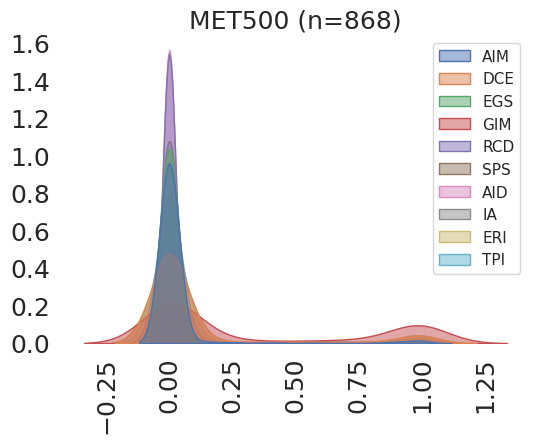

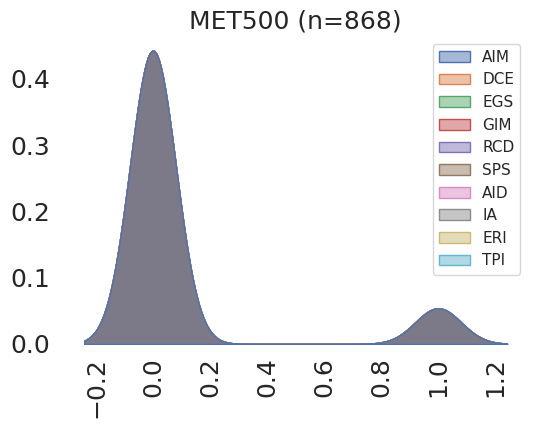

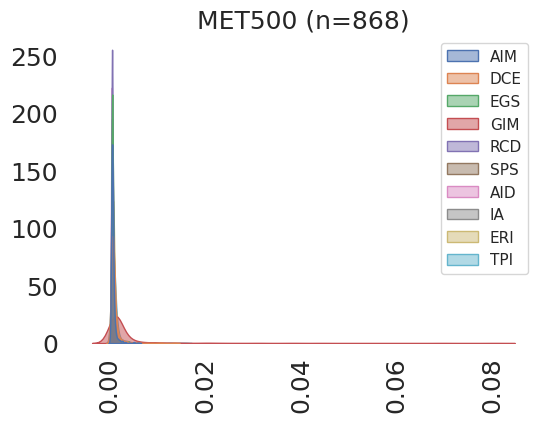

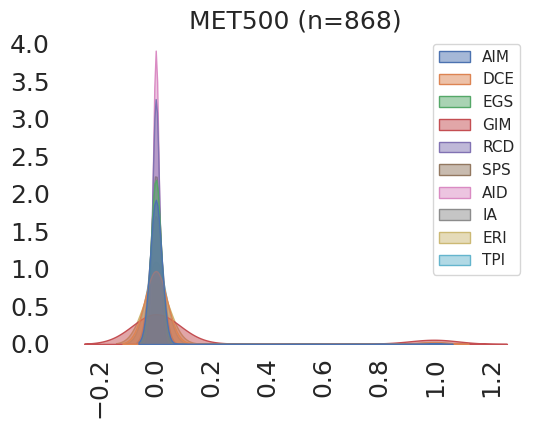

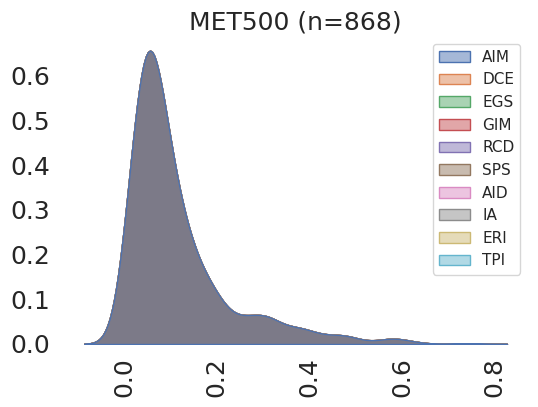

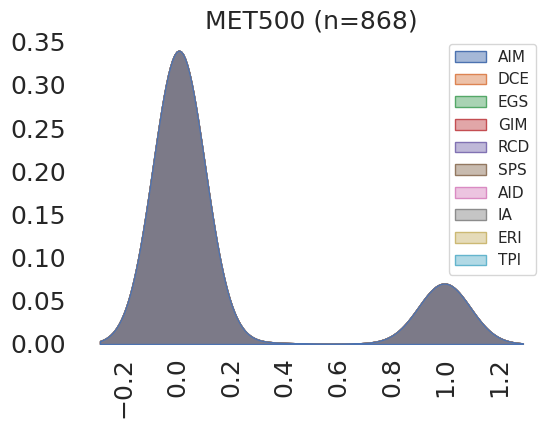

['met1_output_dfs.pkl']

In [68]:
met1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
met1_output_dfs = {}

for model_type in met1_model_types:
    prob_df = pd.DataFrame(index=met1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(met1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "MET500 (n=868)", "MET500", model_type)
    met1_output_dfs[model_type] = prob_df
    
joblib.dump(met1_output_dfs, 'met1_output_dfs.pkl')

In [69]:
# Model Specificity (true negative rate) check on normal GTeX datasets

In [70]:
folder_path = '/data1/Projects/Hallmark/val_data/GTEX_DATA'
gtex_list = []
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file), sep='\t', index_col=1, header=2)
    df = df.iloc[:,1:]
    gtex_list.append(df)

In [71]:
gtex = pd.concat(gtex_list, axis=1)
gtex

,GTEX-N7MS-1526-SM-HAUZP,GTEX-P4QS-1226-SM-HPAG8,GTEX-QEG4-1526-SM-GPRWK,GTEX-QEG5-2026-SM-H6Q6I,GTEX-R55E-2026-SM-EZ6L1,GTEX-RU72-1926-SM-EAZ3F,GTEX-S33H-1526-SM-GQ1CB,GTEX-SIU8-1926-SM-H7OG4,GTEX-T5JC-1626-SM-EZ6KW,GTEX-T6MN-1926-SM-GOQYD,...,GTEX-ZE7O-2226-SM-GNTC2,GTEX-ZLWG-0926-SM-4WWC3,GTEX-ZP4G-0626-SM-4WWF1,GTEX-ZPIC-1426-SM-4WWCP,GTEX-ZTPG-1926-SM-HAUZ1,GTEX-ZVT2-0326-SM-5E44G,GTEX-ZVT3-2626-SM-5GU5L,GTEX-ZYFG-1726-SM-5GZZB,GTEX-ZYY3-2726-SM-5EGH4,GTEX-ZZPU-2126-SM-5EGIU
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0,1,0,0,4,0,0,2,0,0,...,0,2,0,0,0,0,0,0,1,0
WASH7P,61,143,225,196,187,70,146,180,121,135,...,302,204,126,161,212,95,271,106,189,81
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,1,1,0,2
FAM138A,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,76907,218101,37278,15132,58869,108118,68029,41976,66728,37036,...,6409,129875,41470,160955,33074,174382,2152,67733,7802,36073
MT-TE,12,85,5,1,9,13,12,9,12,6,...,0,43,23,52,7,73,3,26,1,15
MT-CYB,1141337,2057999,1208152,166778,1449542,1929581,1108435,1127647,1349266,1171744,...,79685,297413,385597,402274,391350,509080,22728,510387,73555,378247


In [72]:
gtex1 = gtex.T
gtex1 = gtex1.loc[:, ~gtex1.columns.duplicated(keep='first')]
gtex1 = gtex1.reindex(columns = feature_name, fill_value = 0).fillna(0)
gtex1_index = gtex1.index
gtex1_column = gtex1.columns
gtex1 = rankdata(gtex1 * -1, axis=1, method='average')
gtex1 = pd.DataFrame(np.log2(gtex1))
gtex1.index = gtex1_index
gtex1.columns = gtex1_column
gtex1

Description,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
GTEX-N7MS-1526-SM-HAUZP,12.874309,12.340685,11.841761,12.837726,12.466076,11.097374,11.501588,12.857689,9.103288,12.935073,...,3.459432,12.109504,10.244364,11.430714,11.940497,12.574120,9.751544,10.966145,10.198445,13.064995
GTEX-P4QS-1226-SM-HPAG8,12.844019,12.415742,11.934059,12.467733,12.717034,11.296056,12.371504,12.622624,11.305207,13.032993,...,4.392317,11.916999,10.355902,11.957102,12.482052,12.704876,9.269127,12.164750,11.604553,12.786678
GTEX-QEG4-1526-SM-GPRWK,12.826251,12.704660,11.948367,8.087463,12.673861,11.456868,12.225358,11.605480,11.595957,13.038147,...,3.459432,11.881114,10.297490,11.736825,12.122343,12.115369,9.972980,12.444497,11.551228,12.751858
GTEX-QEG5-2026-SM-H6Q6I,12.902469,12.590938,11.211280,10.499846,12.607099,10.668885,12.390975,11.008429,10.732167,12.906797,...,1.584963,12.027215,10.801708,11.647009,12.307058,12.453656,9.319672,12.104599,11.943431,11.629584
GTEX-R55E-2026-SM-EZ6L1,12.865153,12.587074,11.998238,7.507795,12.731531,11.106563,12.106236,11.861087,10.551228,13.028769,...,3.807355,11.595724,10.613329,11.622509,12.253552,12.018026,10.209453,12.695989,11.738937,12.932122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZVT2-0326-SM-5E44G,12.993823,12.245553,12.154976,11.274378,12.577429,10.601771,12.293903,12.900584,10.632086,13.010965,...,1.000000,11.598285,10.943980,11.597587,10.833681,12.085140,11.961811,12.917652,12.361944,12.992319
GTEX-ZVT3-2626-SM-5GU5L,12.985486,12.517546,12.521355,12.050359,12.563673,10.785044,11.856620,12.933967,10.897467,12.947911,...,0.000000,12.093252,10.805744,11.373409,10.327553,10.836445,11.636851,12.735344,11.822770,12.969297
GTEX-ZYFG-1726-SM-5GZZB,12.956467,12.051549,12.312883,10.533330,12.549303,10.629357,12.177264,12.708868,10.751126,12.976922,...,2.321928,11.874021,11.043711,11.493855,10.953469,11.975669,11.928148,12.673088,12.424691,13.003694
GTEX-ZYY3-2726-SM-5EGH4,12.912515,12.537097,12.342908,12.232571,12.440220,10.529431,12.015415,12.854089,11.375854,12.972621,...,1.000000,12.166634,10.614710,11.440610,10.763212,11.165535,11.424691,12.696533,12.153077,13.011577


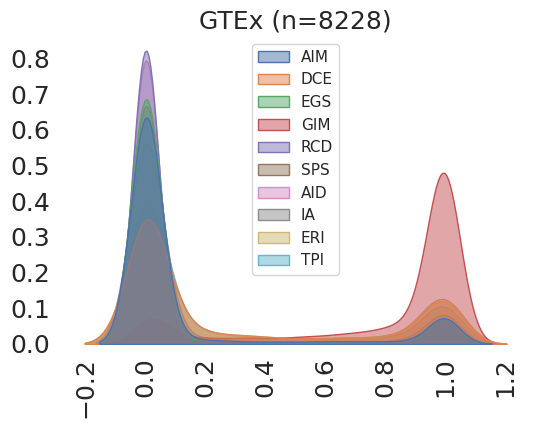

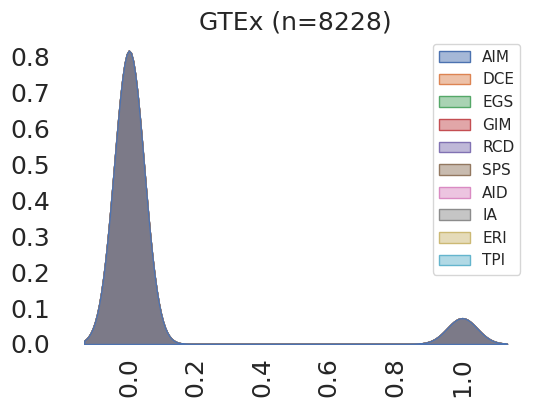

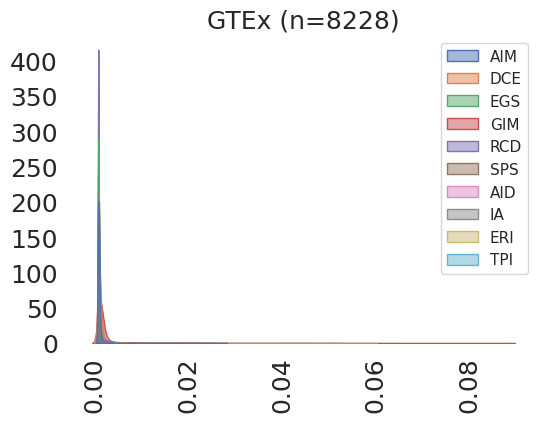

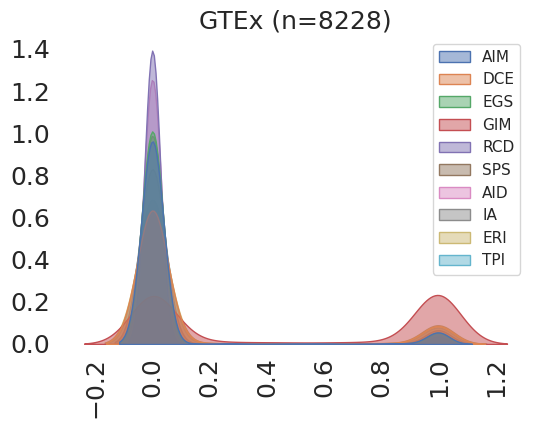

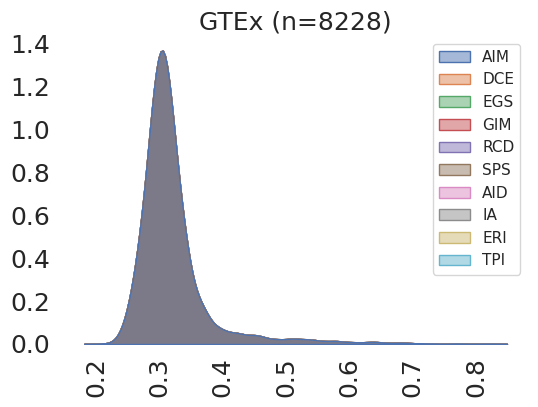

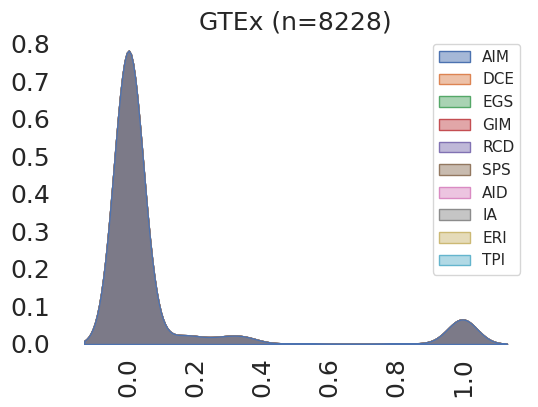

['gtex_output_dfs.pkl']

In [75]:
gtex1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
gtex1_output_dfs = {}

for model_type in gtex1_model_types:
    prob_df = pd.DataFrame(index=gtex1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(gtex1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "GTEx (n=8228)", "GTEx", model_type)
    gtex1_output_dfs[model_type] = prob_df
    
joblib.dump(gtex1_output_dfs, 'gtex_output_dfs.pkl')

# Model Sensitivity (true positive rate) check on primary cancer TCGA datasets

In [78]:
tcga = pd.read_csv('/data1/Projects/Hallmark/tcga_data.tsv', sep='\t')
new_col = tcga['gene_id'].str.split('|').str[0]
tcga.drop(['gene_id'], axis=1, inplace=True)
tcga.insert(0, 'Hugo', new_col)
tcga = tcga.set_index('Hugo')
tcga = tcga[~(tcga.index).isin(['?'])]
tcga = tcga.fillna(0).astype(int)
tcga.columns = tcga.columns.str[:15]
tcga = tcga[[col for col in tcga.columns if not col[-2:] in ['10', '11', '12', '13', '14']]]
tcga.columns = tcga.columns.str[:-3]
tcga = tcga.T
tcga = tcga[~tcga.index.duplicated(keep='first')]
tcga

Hugo,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-OR-A5J1,16,0,17,182,10373,54,190,0,0,2225,...,183,146,20,351,1050,0,648,1841,1157,596
TCGA-OR-A5J2,9,0,5,239,9844,0,198,0,0,1509,...,264,438,57,279,2979,31,1166,3059,1895,801
TCGA-OR-A5J3,20,0,8,138,7201,1,75,2,0,1259,...,90,190,39,495,914,0,806,2655,1482,437
TCGA-OR-A5J5,1696,1,6,63,2939,49,374,0,0,2993,...,260,840,17,206,890,11,553,2367,1140,512
TCGA-OR-A5J6,600,0,4,237,9586,1,1556,0,0,1186,...,64,63,12,117,894,7,795,708,796,475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-CG-4472,14,0,0,150,33395,0,349,23,0,433,...,292,450,79,509,1224,3,905,3359,1740,1148
TCGA-CG-4474,37,0,0,196,21828,0,198,43,0,946,...,745,1056,39,349,970,17,757,4264,2702,857
TCGA-CG-4475,16,0,0,68,20825,0,482,0,0,493,...,556,655,59,554,1308,3,927,3103,1370,473
TCGA-CG-4476,24,0,0,169,34248,0,263,90,0,454,...,516,608,45,464,1101,0,845,3302,1915,1027


In [79]:
cancer_types = ['BRCA', 'OV', 'PRAD', 'LAML', 'DLBC', 'LUAD', 'LUSC', 'SARC', 'COAD', 'READ', 'SKCM',
                'LIHC', 'KICH', 'KIRC', 'KIRP', 'HNSC', 'PAAD', 'LGG', 'GBM']

In [80]:
tcga_meta = pd.read_csv('/data1/Projects/Hallmark/patient_info.csv', index_col=(0))
tcga_meta = tcga_meta[['CANCER_TYPE_ACRONYM']]
tcga_meta = tcga_meta[tcga_meta['CANCER_TYPE_ACRONYM'].isin(cancer_types)]
tcga_meta = tcga_meta[~tcga_meta.index.duplicated(keep='first')]
tcga_meta

,CANCER_TYPE_ACRONYM
PATIENT_ID,
TCGA-2K-A9WE,KIRP
TCGA-2Z-A9J1,KIRP
TCGA-2Z-A9J2,KIRP
TCGA-2Z-A9J3,KIRP
TCGA-2Z-A9J5,KIRP
...,...
TCGA-ZP-A9D4,LIHC
TCGA-ZS-A9CD,LIHC
TCGA-ZS-A9CE,LIHC


In [81]:
common_sample = list(set(tcga.index) & set(tcga_meta.index))
len(common_sample)

6967

In [82]:
tcga1 = tcga[tcga.index.isin(common_sample)]
tcga1 = tcga1.loc[:, ~tcga1.columns.duplicated(keep='first')]
tcga1 = tcga1.reindex(columns = feature_name, fill_value = 0).fillna(0)
tcga1_index = tcga1.index
tcga1_columns = tcga1.columns
tcga1 = rankdata(tcga1 * -1, axis=1, method='average')
tcga1 = pd.DataFrame(np.log2(tcga1))
tcga1.index = tcga1_index
tcga1.columns = tcga1_columns
tcga1

Hugo,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
TCGA-FA-8693,12.807254,12.046442,12.588598,12.780335,11.770457,9.967947,13.091931,12.733015,9.278449,11.879966,...,2.321928,12.753844,10.471675,11.069450,12.159241,12.230921,12.503950,11.641826,10.227616,12.952650
TCGA-FA-A4BB,12.678600,11.992230,12.723661,12.367415,12.155767,10.431498,13.090609,12.506060,9.909893,12.313450,...,1.584963,12.389497,10.528454,10.773139,12.200439,11.785657,12.816984,12.600261,10.603626,12.571634
TCGA-FA-A4XK,11.845490,11.879583,12.812478,12.321505,12.002288,11.093748,13.088788,12.801001,10.306062,12.361533,...,2.321928,12.696968,11.005625,11.253552,11.219774,12.266787,12.098690,11.990459,11.534060,12.741467
TCGA-FA-A6HN,12.057823,12.053247,12.484194,12.741046,12.182394,10.564149,13.088043,12.420092,9.938109,12.286847,...,2.000000,12.450438,10.804938,11.434368,12.446179,10.598053,12.792485,12.467096,11.949644,12.767874
TCGA-FA-A6HO,12.615745,12.224906,12.512123,12.788209,12.391512,10.357552,13.087877,12.567124,10.293472,12.514344,...,3.000000,12.243025,10.897089,11.723661,12.168202,10.486835,12.705200,12.469260,11.420487,12.662780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AB-3007,12.375175,12.110320,11.606174,12.684529,12.526866,10.718533,13.070959,12.908299,10.272047,12.759888,...,1.584963,11.536004,11.341241,11.505067,12.041830,10.971184,12.938753,12.444756,11.333155,13.070959
TCGA-AB-3008,12.479907,12.116831,11.839204,12.348728,12.446696,10.666224,13.079235,12.839991,9.881114,12.681897,...,0.000000,11.689561,11.286269,11.449665,10.797662,11.308339,12.852042,12.550146,11.604322,13.079235
TCGA-AB-3009,12.596889,12.061202,11.746724,12.858078,12.563554,10.382084,13.076983,12.915132,9.918863,12.800698,...,0.000000,11.361396,11.768805,11.544240,10.795228,11.535518,12.905199,12.727070,11.679260,13.076983
TCGA-AB-3011,12.530040,11.939946,12.231971,6.643856,12.552549,10.512740,13.077150,12.866893,10.241387,12.624110,...,0.000000,11.196602,11.599448,11.392586,11.111462,11.702173,12.899168,12.484445,11.517177,13.077150


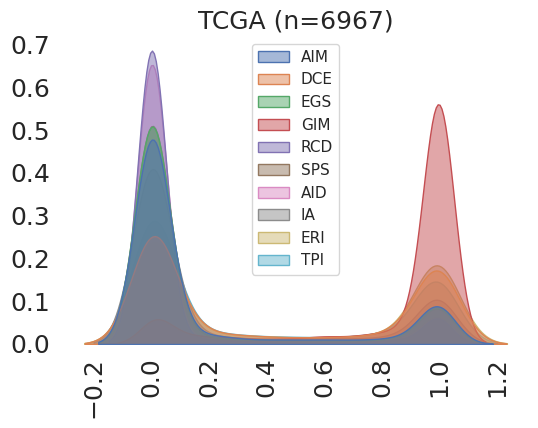

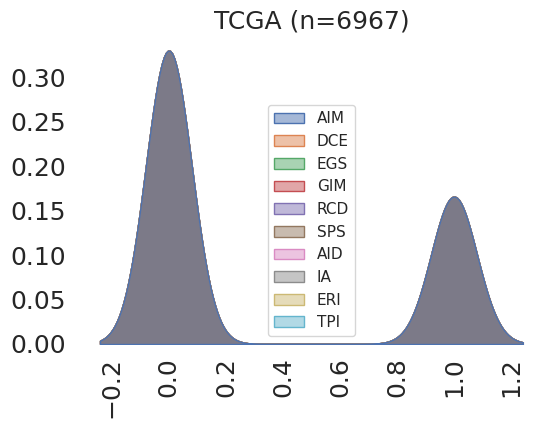

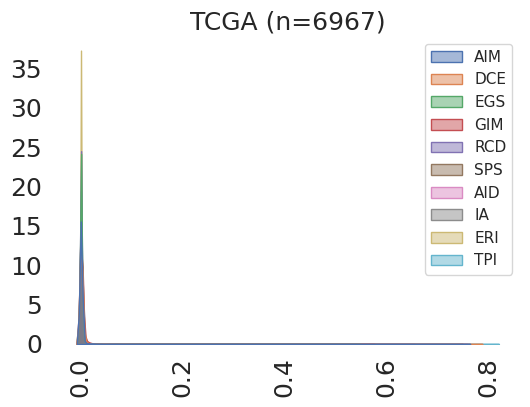

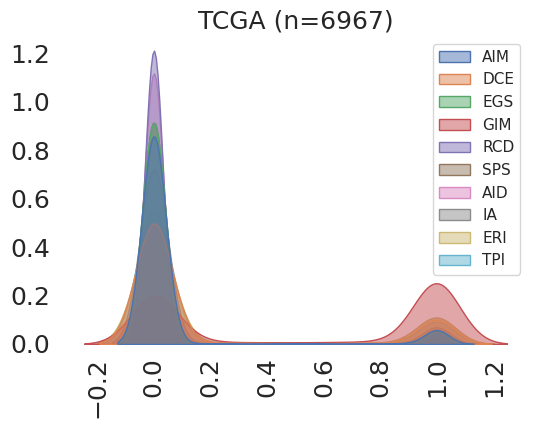

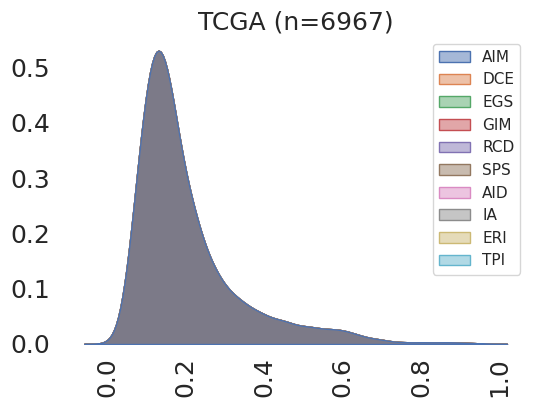

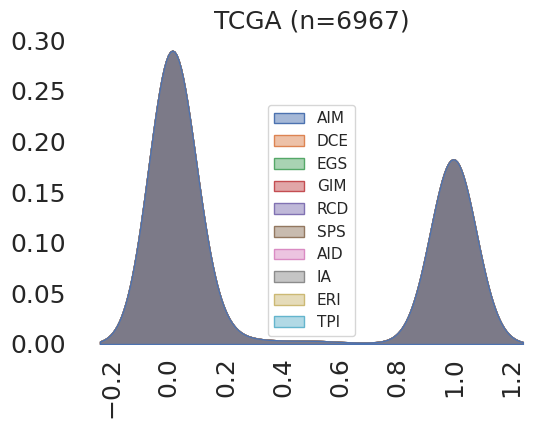

['tcga_output_dfs.pkl']

In [83]:
tcga1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
tcga1_output_dfs = {}

for model_type in tcga1_model_types:
    prob_df = pd.DataFrame(index=tcga1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(tcga1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "TCGA (n=6967)", "TCGA", model_type)
    tcga1_output_dfs[model_type] = prob_df
    
joblib.dump(tcga1_output_dfs, 'tcga_output_dfs.pkl')

# Model Sensitivity (true positive rate) check on primary cancer POG570 datasets

In [85]:
folder_path = '/data1/Projects/Hallmark/val_data/POG570'
pog_list = []
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file), sep='\t', index_col=0)
    df = df[['expected_count']]
    df.columns = [file.split('_')[0]]
    pog_list.append(df)

In [86]:
pog = pd.concat(pog_list, axis=1)
pog_gene = ensembl_to_hugo(pog.index).set_index('ENSEMBL_ID')
pog_gene = pog_gene[['HGNC_ID']]
pog = pd.concat([pog_gene, pog], axis=1).dropna().set_index('HGNC_ID')
pog

,30253,25500,20801,24464,38261,25426,30248,25719,27177,23676,...,28668,23411,30519,31194,13577,30500,25657,25134,34332,25358
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
WASH7P,42.0,8.0,3.0,40.00,104.0,34.0,81.0,51.0,22.0,26.0,...,71.0,48.0,47.0,81.0,23.0,122.0,25.0,9.0,121.0,14.0
MIR1302-11,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM138A,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4G4P,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y_RNA,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WI2-2610K16.1,20.0,17.0,1.0,50.00,74.0,0.0,3.0,72.0,14.0,100.0,...,13.0,0.0,0.0,0.0,21.0,160.0,20.0,20.0,0.0,0.0
WI2-2942J8.1,2.0,0.0,12.0,0.00,7.0,3.0,5.0,0.0,4.0,0.0,...,0.0,7.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0


In [87]:
pog1 = pog.T
pog1 = pog1.loc[:, ~pog1.columns.duplicated(keep='first')]
pog1 = pog1.reindex(columns = feature_name, fill_value = 0).fillna(0)
pog1_index = pog1.index
pog1_columns = pog1.columns
pog1 = rankdata(pog1 * -1, axis=1, method='average')
pog1 = pd.DataFrame(np.log2(pog1))
pog1.index = pog1_index
pog1.columns = pog1_columns
pog1

HGNC_ID,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
30253,12.921748,12.107381,12.491728,9.684749,12.766218,11.539159,12.399812,12.900018,9.700440,13.037890,...,2.000000,11.627990,11.529431,12.015067,11.000000,12.029805,11.133142,12.732697,12.206709,10.018200
25500,12.891594,12.341519,10.605480,11.412570,12.798573,11.422065,12.400879,12.885220,10.360298,12.993115,...,3.000000,11.889504,12.299780,12.309761,11.638888,11.943797,11.404077,11.772727,12.115694,9.329796
20801,12.966956,12.316706,12.457637,7.900867,12.743993,12.155134,12.556746,12.952286,10.230020,13.044480,...,4.087463,11.788922,11.955650,12.445274,9.890264,12.389766,11.038919,12.843234,12.741467,10.682117
24464,12.704768,11.575066,11.605480,12.735344,12.503826,11.090774,11.811375,12.734710,9.756556,13.045504,...,3.169925,11.437232,11.463780,11.675075,12.015415,12.727495,11.200286,12.879296,12.300067,9.221587
38261,12.836050,12.466204,12.814582,12.200899,12.676618,11.725366,12.430975,12.813481,9.129283,13.032304,...,3.321928,11.889504,11.256209,11.816184,11.220378,11.452756,10.796040,12.767874,12.251482,12.288578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30500,12.888077,12.458022,11.885887,12.228368,12.504571,11.534303,12.709945,12.605480,10.992938,12.977459,...,3.000000,12.557823,11.005625,12.061034,11.343741,10.903882,9.865733,12.689780,12.074810,5.285402
25657,12.887887,12.226563,12.095891,11.669328,12.714782,11.281351,12.594558,12.574594,10.070121,13.015067,...,3.906891,11.785044,11.447858,11.820578,10.607330,12.067266,10.703904,12.783101,12.014718,8.569856
25134,12.898885,12.552789,12.625595,11.898034,11.745044,11.572227,12.038919,12.795228,9.816184,12.995414,...,3.807355,12.105581,11.549063,11.622967,11.082149,12.869112,11.638888,12.613674,11.780130,9.167418
34332,12.897562,12.234368,10.668885,12.749136,12.697619,11.504322,12.509775,12.768184,10.967226,13.011926,...,4.247928,12.244958,10.549785,11.906515,12.009129,12.019069,9.938109,12.760928,11.884934,12.986909


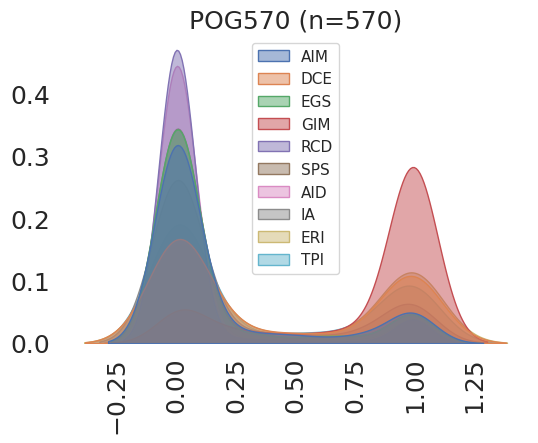

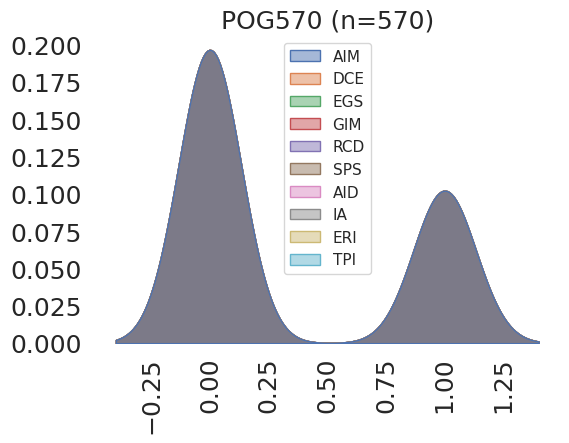

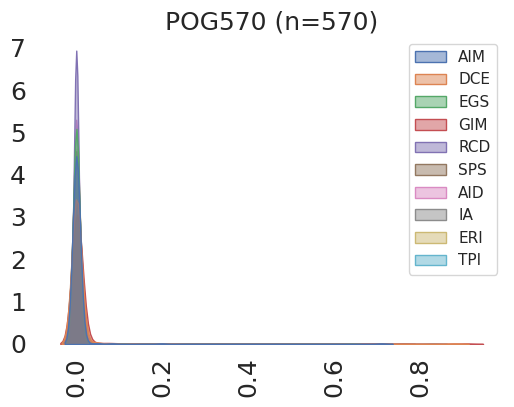

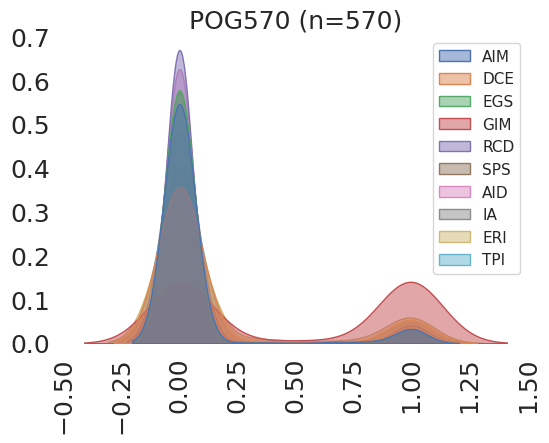

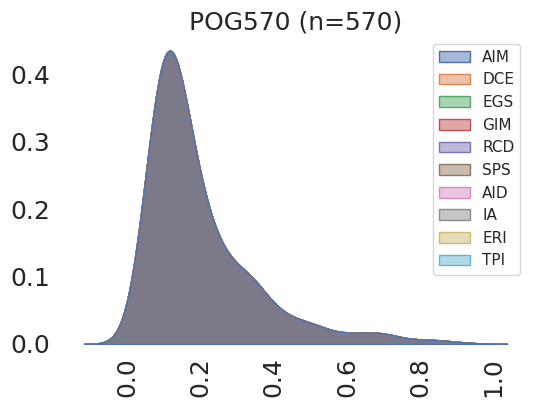

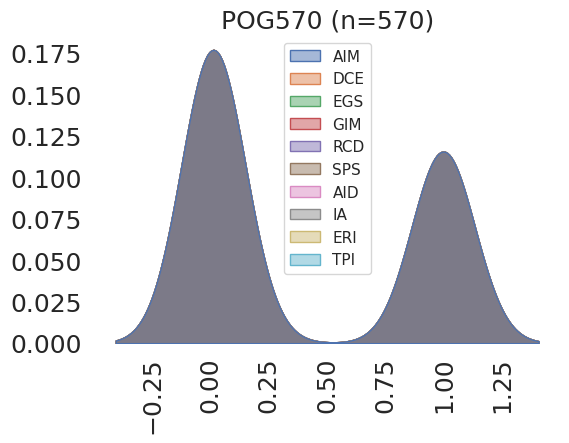

['pog_output_dfs.pkl']

In [88]:
pog1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
pog1_output_dfs = {}

for model_type in pog1_model_types:
    prob_df = pd.DataFrame(index=pog1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(pog1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "POG570 (n=570)", "POG570", model_type)
    pog1_output_dfs[model_type] = prob_df
    
joblib.dump(pog1_output_dfs, 'pog_output_dfs.pkl')

# Model Sensitivity (true positive rate) check on primary cancer CCLE datasets

In [92]:
ccle = pd.read_csv('CCLE_data.gct', sep='\t', index_col=1, header=2)
ccle = ccle.iloc[:,1:]
ccle

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
Description,,,,,,,,,,,,,,,,,,,,,
DDX11L1,12,8,8,6,2,1,4,3,4,7,...,18,14,40,39,25,14,11,5,13,6
WASH7P,1340,821,678,677,884,868,611,692,639,728,...,562,328,663,270,233,558,309,811,500,945
MIR1302-11,4,1,3,3,2,6,3,4,4,2,...,11,7,24,24,20,6,3,1,6,5
FAM138A,6,3,2,4,1,4,3,1,2,3,...,14,16,31,19,24,8,7,0,10,4
OR4G4P,0,2,3,1,1,0,1,2,0,2,...,8,3,15,7,5,3,5,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,124017,112857,136078,254975,106503,92152,134020,96755,78693,101470,...,64989,55308,167546,158012,65175,56555,37417,55576,42767,159531
MT-TE,42,23,11,33,22,29,349,23,15,24,...,13,6,20,56,19,15,12,23,9,21
MT-CYB,695276,457726,250709,589478,316056,322152,302756,232040,403043,591424,...,90995,196872,850259,383806,184011,144686,85061,242084,89457,689477


In [93]:
ccle1 = ccle.T
ccle1 = ccle1.loc[:, ~ccle1.columns.duplicated(keep='first')]
ccle1 = ccle1.reindex(columns = feature_name, fill_value = 0).fillna(0)
ccle1_index = ccle1.index
ccle1_columns = ccle1.columns
ccle1 = rankdata(ccle1 * -1, axis=1, method='average')
ccle1 = pd.DataFrame(np.log2(ccle1))
ccle1.index = ccle1_index
ccle1.columns = ccle1_columns
ccle1

Description,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
22RV1_PROSTATE,12.777050,11.409391,12.115856,12.661333,12.545085,11.414685,12.378159,13.133223,8.344296,13.062636,...,2.321928,11.528210,10.782998,10.965063,12.301210,12.821973,12.168829,12.730046,11.753217,12.867665
2313287_STOMACH,12.754783,11.371232,11.761343,12.696207,12.476873,11.120238,12.064911,13.129605,9.262095,13.129605,...,2.000000,11.465566,11.315999,12.200132,12.145614,12.321083,12.061877,12.814683,11.822969,8.710806
253JBV_URINARY_TRACT,12.716176,11.765286,11.502335,12.933506,11.909706,11.838810,11.689124,13.136511,10.241983,12.985041,...,1.584963,12.157978,11.135709,11.505812,12.422853,11.727920,10.709945,12.179754,11.546653,9.493855
253J_URINARY_TRACT,12.830119,11.726644,10.880349,12.962896,11.781155,12.181308,10.186114,13.071211,9.715962,13.037461,...,3.000000,12.209758,10.994353,11.661333,12.597471,11.467351,11.621136,11.878243,11.223097,10.370687
42MGBA_CENTRAL_NERVOUS_SYSTEM,12.883121,12.087629,10.916626,11.331757,12.562362,11.620220,12.404476,13.078901,10.375583,12.940314,...,3.000000,11.453271,10.833681,11.720030,11.858175,12.575066,10.482808,12.654412,11.832692,12.875749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YD8_UPPER_AERODIGESTIVE_TRACT,12.917279,12.464035,12.128155,11.853115,12.646109,11.522091,12.103780,13.060865,10.369052,12.606983,...,1.584963,10.999648,11.776022,11.768184,11.915319,12.118454,10.735556,12.706496,12.418511,10.511753
YH13_CENTRAL_NERVOUS_SYSTEM,12.905387,11.308908,11.022021,11.514714,12.656648,11.203042,12.524909,13.043455,9.524542,12.872386,...,2.584963,11.433064,11.423904,11.391244,11.267957,12.197677,10.977995,12.660330,12.266054,12.495730
YKG1_CENTRAL_NERVOUS_SYSTEM,12.878817,12.203348,11.863799,10.726218,12.513728,11.725792,12.370687,13.136751,9.411511,12.971813,...,1.584963,12.357277,10.550747,11.859146,9.902375,12.566054,9.870365,12.567718,11.986553,12.976654
ZR751_BREAST,12.850871,11.365502,12.529919,12.193063,12.438142,11.963799,11.713387,13.031443,7.400879,13.064490,...,1.000000,11.621594,11.829326,11.884934,12.464673,12.824462,11.821774,12.070289,11.553149,12.833582


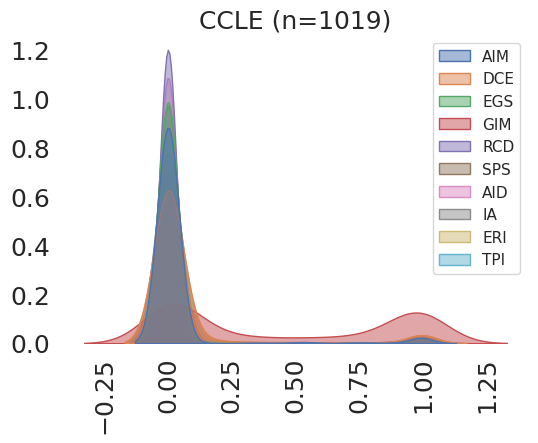

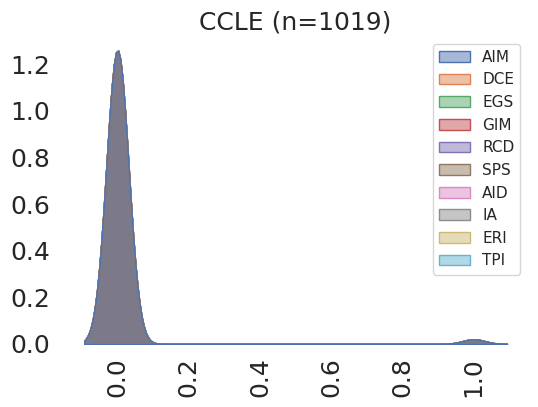

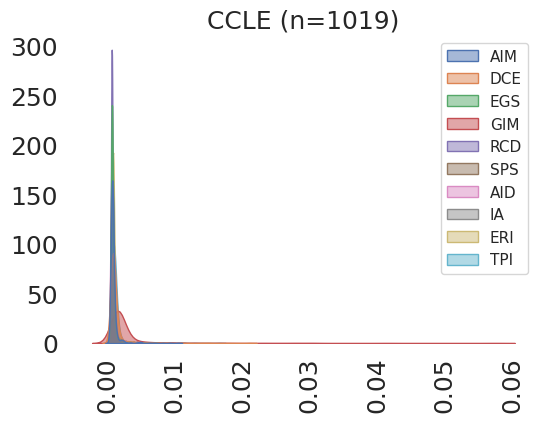

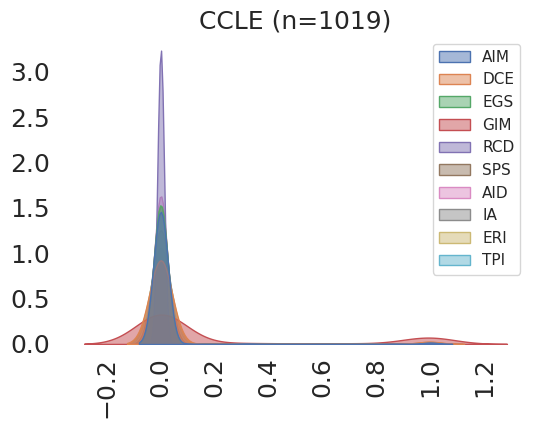

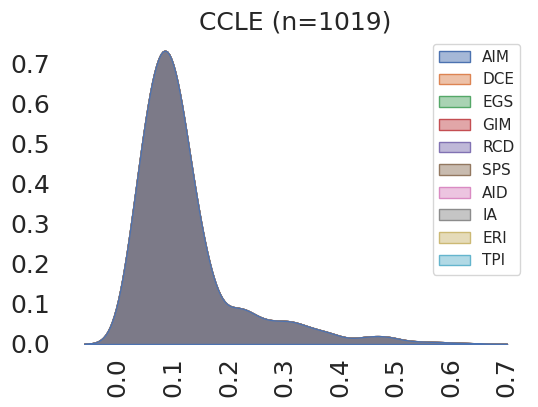

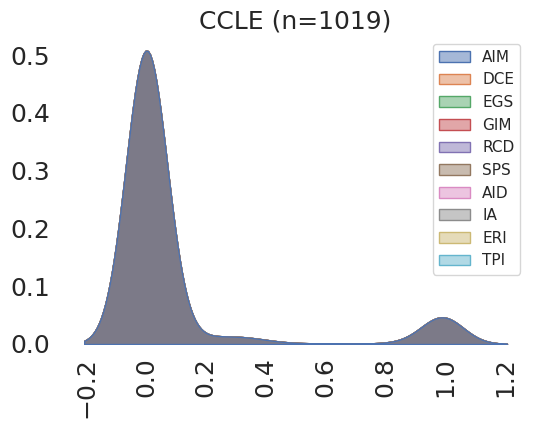

['ccle_output_dfs.pkl']

In [94]:
ccle1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
ccle1_output_dfs = {}

for model_type in ccle1_model_types:
    prob_df = pd.DataFrame(index=ccle1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(ccle1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "CCLE (n=1019)", "CCLE", model_type)
    ccle1_output_dfs[model_type] = prob_df
    
joblib.dump(ccle1_output_dfs, 'ccle_output_dfs.pkl')

# Model Sensitivity (true positive rate) check on primary cancer TARGET datasets

In [90]:
target = pd.read_csv('target_data.txt', sep='\t', index_col=0)
target.index = target.index.str.split('.').str[0]
target = target[~target.index.duplicated(keep='first')]
target_gene = ensembl_to_hugo(target.index).set_index('ENSEMBL_ID')
target_gene = target_gene[['HGNC_ID']]
target = pd.concat([target_gene, target], axis=1).dropna().set_index('HGNC_ID')
target

,TARGET-30-PASWYR-01,TARGET-20-PARUBT-09,TARGET-30-PASNZU-01,TARGET-52-PASDLA-11,TARGET-50-PAKNRX-01,TARGET-30-PASWFB-01,TARGET-30-PALUYS-01,TARGET-30-PAUDDK-01,TARGET-10-PAPZNK-09,TARGET-50-PAJLNJ-01,...,TARGET-20-PANLIZ-04,TARGET-21-PASSLT-41,TARGET-20-PASTTW-09,TARGET-50-PAKYLT-01,TARGET-20-PATJHJ-09,TARGET-21-PATKKJ-41,TARGET-10-PAPEJN-04,TARGET-20-PABLDZ-09,TARGET-10-PANSBR-09,TARGET-10-PARFLV-04
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.0000,0.0000,0.0000,2.2418,4.1914,0.0000,0.0000,2.4330,0.0000,3.2234,...,0.0000,5.5326,4.4489,4.9805,0.0000,4.5298,0.0000,4.0259,4.3978,0.0000
WASH7P,9.9768,7.7874,10.8310,9.3506,9.5416,9.7886,7.9097,8.8859,8.7006,9.5699,...,10.4021,5.2388,10.1994,9.6483,10.7380,3.5777,9.8351,8.5780,10.3921,7.2897
MIR1302-11,1.9523,0.0000,0.0000,0.0000,0.0000,2.1699,2.8836,0.0000,0.0000,3.9011,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.1110,0.0000,0.7740,0.0000,0.0000
FAM138A,0.0000,0.0000,0.0000,0.0976,0.1110,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.4751,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
OR4G4P,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WI2-2610K16.1,1.5850,0.0000,0.0000,7.2095,4.2479,0.0000,3.0000,0.0000,7.3837,2.8074,...,2.5850,0.0000,1.0000,6.2095,5.7549,1.5850,8.9248,3.0000,7.1293,6.9189
WI2-2942J8.1,5.7004,2.0000,6.8455,2.5850,3.0000,5.8074,4.4594,2.5850,5.0000,1.0000,...,2.5850,4.7549,1.5850,2.8074,3.9069,3.0000,8.0112,4.0000,6.4594,4.5236
XX-CR54.3,6.2327,4.6439,3.8074,3.1699,1.0000,0.0000,2.8074,1.0000,2.0000,0.0000,...,2.0000,0.0000,3.0000,1.5850,1.5850,2.8074,1.5850,2.8074,1.0000,1.0000


In [95]:
target1 = target.T
target1 = target1.loc[:, ~target1.columns.duplicated(keep='first')]
target1 = target1.reindex(columns = feature_name, fill_value = 0).fillna(0)
target1_index = target1.index
target1_columns = target1.columns
target1 = rankdata(target1 * -1, axis=1, method='average')
target1 = pd.DataFrame(np.log2(target1))
target1.index = target1_index
target1.columns = target1_columns
target1

HGNC_ID,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
TARGET-30-PASWYR-01,12.584728,11.390169,12.703579,12.117968,12.401813,10.544964,10.970465,12.799585,8.348728,13.026523,...,1.584963,12.228668,10.291746,11.109178,10.009829,12.678600,11.075145,12.661110,11.458919,13.042856
TARGET-20-PARUBT-09,10.611025,11.087794,11.896522,12.625366,12.343463,9.754888,12.104763,13.119265,10.830515,11.243769,...,4.000000,12.463652,10.738515,12.540370,11.579787,12.495106,12.687266,12.559975,11.740624,13.013584
TARGET-30-PASNZU-01,12.407002,11.781360,12.792790,12.565340,12.514468,10.755722,11.005975,12.829822,8.714246,12.993823,...,1.584963,12.055791,11.329236,11.004220,10.127994,12.539401,11.590821,12.547738,11.776022,13.053502
TARGET-52-PASDLA-11,12.935718,12.429930,12.098690,10.037547,12.720565,11.617927,11.972800,12.612638,9.539159,12.960183,...,3.321928,11.775610,10.963619,11.974773,10.917372,12.094902,10.598053,12.678930,11.812979,11.689780
TARGET-50-PAKNRX-01,11.912141,12.167418,12.102304,9.189825,12.583553,10.714246,11.200286,12.993292,7.442943,13.017765,...,0.000000,11.300353,11.580730,11.799484,10.207624,12.822770,11.314583,12.907642,12.512000,12.008254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET-21-PATKKJ-41,11.819381,11.207624,11.978174,12.844608,12.139871,10.455327,11.622967,13.011227,8.199672,12.708006,...,0.000000,12.099019,9.912141,10.771489,11.379920,12.247631,12.988951,12.829921,11.318543,13.125978
TARGET-10-PAPEJN-04,12.549544,11.050869,12.434628,12.901527,12.626736,9.405141,11.989749,13.027301,9.694358,12.932030,...,2.807355,11.463524,11.232421,11.768598,11.576248,11.515700,12.990281,12.650715,12.232121,13.131535
TARGET-20-PABLDZ-09,12.118941,11.208539,12.390169,12.815683,12.142586,10.066089,12.604785,13.123313,10.461991,12.413099,...,3.584963,12.392452,11.354800,11.902375,11.914759,11.963619,13.034799,12.379649,10.709515,13.123313
TARGET-10-PANSBR-09,11.899546,10.737247,12.001760,12.959278,12.498351,8.209453,12.079651,13.129041,9.357552,12.844019,...,3.321928,11.559377,10.467606,11.642503,12.070792,11.323055,13.054859,12.681019,12.431236,13.129041


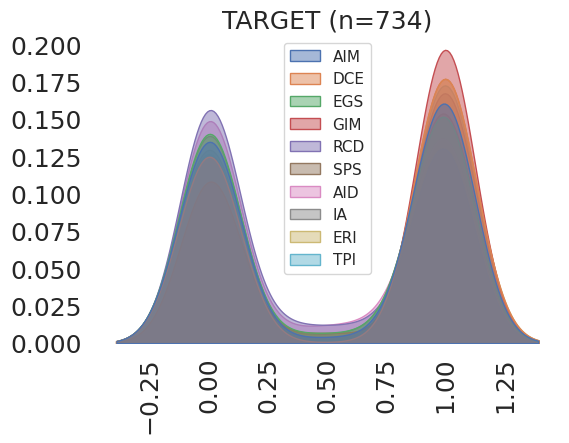

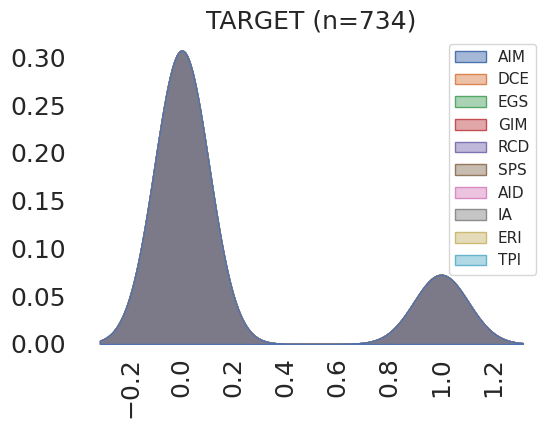

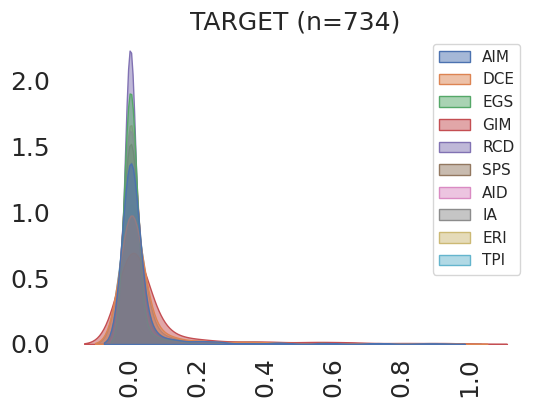

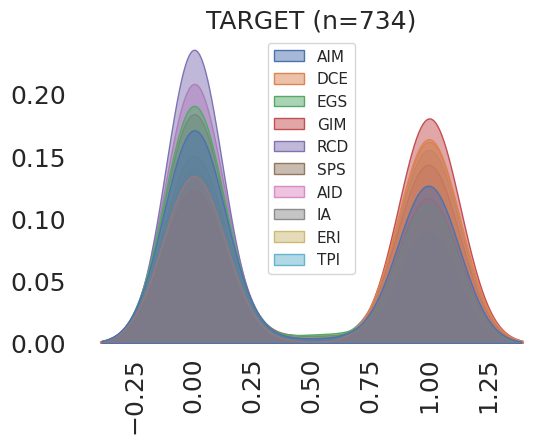

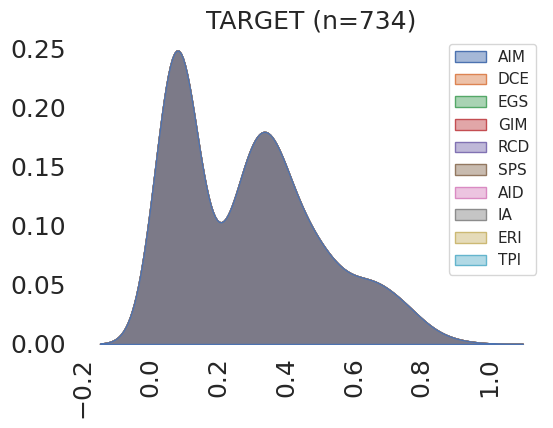

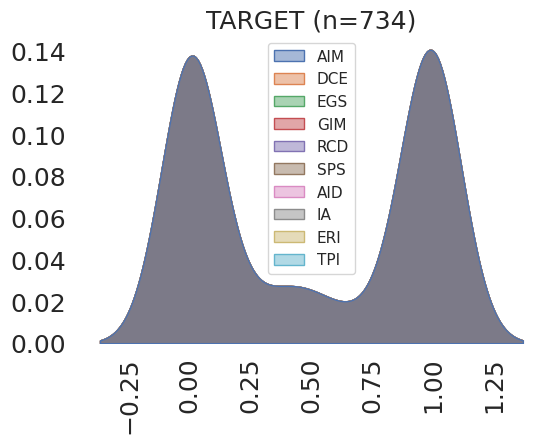

['target_output_dfs.pkl']

In [96]:
target1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
target1_output_dfs = {}

for model_type in target1_model_types:
    prob_df = pd.DataFrame(index=target1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(target1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "TARGET (n=734)", "TARGET", model_type)
    target1_output_dfs[model_type] = prob_df
    
joblib.dump(target1_output_dfs, 'target_output_dfs.pkl')

# Model Sensitivity (true positive rate) check on primary cancer PCAWG datasets

In [97]:
pcawg = pd.read_csv('pcawg_data_mrna_seq_fpkm.txt', sep='\t', index_col=0)
pcawg = pcawg[~pcawg.index.duplicated(keep='first')]
pcawg

,SP89389,SP21193,SP13206,SP103623,SP32742,SP111095,SP8394,SP87446,SP36586,SP123902,...,SP15656,SP123888,SP59420,SP116679,SP1377,SP16269,SP122676,SP88776,SP64546,SP21057
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,65.515874,93.507754,15.155525,9.751670,16.048850,22.724550,29.154328,18.058406,15.486367,43.248311,...,0.000000,27.329458,3.633029,2.302684,227.790781,0.007476,9.736614,29.283034,28.045150,62.010994
TNMD,0.046881,0.655002,0.000000,0.188735,0.014542,0.000000,0.110858,0.031887,0.000000,0.118371,...,0.000000,0.033938,0.064275,0.414507,0.345589,0.000000,0.062405,0.000000,0.026696,0.405261
DPM1,63.315522,23.608843,42.136192,14.507132,45.302557,24.728471,22.578201,21.447736,19.492883,20.331784,...,18.197652,38.290606,35.459968,31.888606,34.589654,23.290497,31.444337,23.118048,51.549932,30.790944
SCYL3,2.222857,1.933762,2.318698,2.342167,4.373694,4.050503,3.372809,2.359359,1.930601,1.886838,...,4.735389,1.356212,4.340347,5.257385,2.496924,6.466530,1.072155,3.699246,1.989817,3.313589
C1orf112,2.565836,1.861716,2.870440,0.454312,4.125029,1.877498,1.999630,0.747373,0.501911,0.369148,...,6.592257,0.259415,1.864762,2.262558,1.257206,6.384945,1.207673,0.539174,1.556905,1.757992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BX649553.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BX649553.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BX649553.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [98]:
pcawg1 = pcawg.T
pcawg1 = pcawg1.loc[:, ~pcawg1.columns.duplicated(keep='first')]
pcawg1 = pcawg1.reindex(columns = feature_name, fill_value = 0).fillna(0)
pcawg1_index = pcawg1.index
pcawg1_columns = pcawg1.columns
pcawg1 = rankdata(pcawg1 * -1, axis=1, method='average')
pcawg1 = pd.DataFrame(np.log2(pcawg1))
pcawg1.index = pcawg1_index
pcawg1.columns = pcawg1_columns
pcawg1

Hugo_Symbol,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
SP89389,12.015415,12.272047,12.028597,12.247631,12.064406,10.253847,11.223398,12.903317,7.491853,13.039090,...,3.321928,11.873444,11.614710,11.937742,12.266787,12.831505,11.751962,12.789737,11.691307,11.734286
SP21193,12.925554,12.265029,12.581907,11.903505,11.883789,11.961450,12.811375,11.861475,9.483816,12.635945,...,4.459432,12.753008,10.056638,11.161132,12.172428,12.588012,10.861087,11.283667,8.592457,10.113742
SP13206,12.968487,12.706712,12.474720,12.501340,11.249706,11.213712,12.629584,12.882261,8.816984,11.805744,...,6.727920,12.829525,10.950556,11.230020,12.893112,11.481799,12.436712,12.136030,9.766529,12.070792
SP103623,13.015067,12.827343,12.593625,12.311181,11.832099,12.100991,12.608948,10.189825,10.167418,11.667555,...,6.266787,12.773139,10.759056,10.909143,13.020980,11.829723,12.010878,10.944712,9.810572,12.863025
SP32742,12.922956,12.862444,11.826548,11.090112,11.931476,10.953469,12.818183,12.749450,8.370687,12.709945,...,5.129283,12.487086,10.651052,11.185495,12.277869,11.879200,12.781770,12.505812,10.276124,10.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP16269,12.089119,12.353423,12.696968,12.985486,12.127994,10.766529,12.483312,12.941231,9.381543,12.220076,...,4.392317,12.536004,11.391781,10.479780,12.572227,8.535275,13.115775,12.694358,12.250595,13.115775
SP122676,13.031529,12.550266,11.642052,11.632541,11.679480,11.398744,12.659996,12.217958,9.629357,11.934428,...,7.149747,12.850968,9.797662,10.966505,12.889884,12.373953,10.634811,11.241387,9.299208,13.049508
SP88776,12.880349,12.479780,12.255619,12.890074,12.281930,11.107871,12.560810,12.497353,8.361944,12.923327,...,3.700440,12.392049,10.111136,11.505812,11.987975,12.849210,11.871520,12.455327,10.365229,9.779719
SP64546,13.017330,12.672425,12.571279,12.406736,11.917745,11.879583,12.302924,12.594091,7.665336,12.690435,...,4.392317,12.963438,11.362492,11.861862,11.672867,12.303495,11.902752,12.067770,11.106563,9.741467


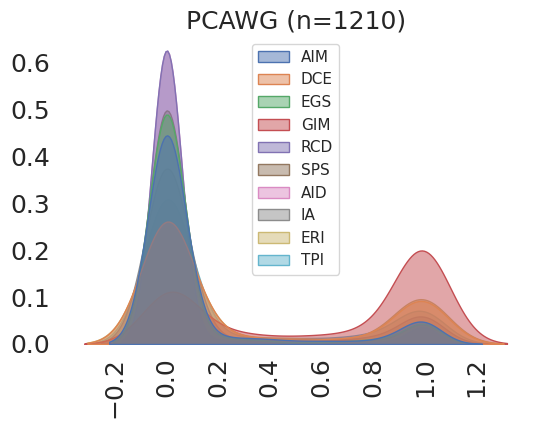

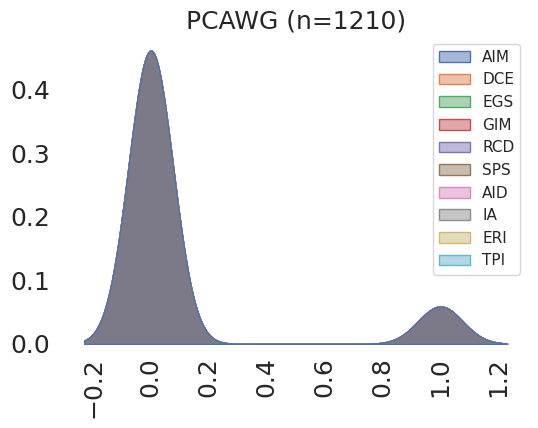

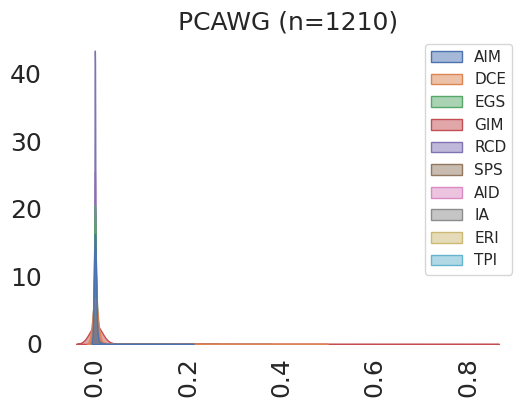

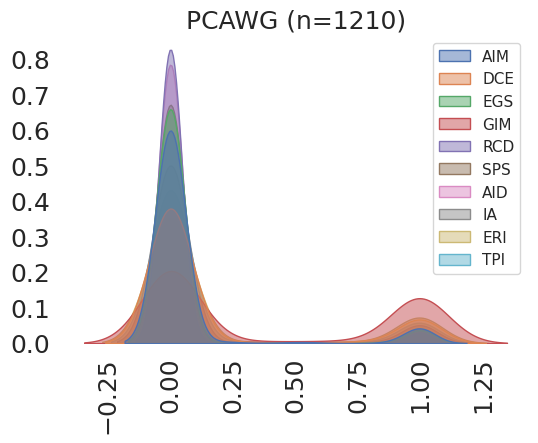

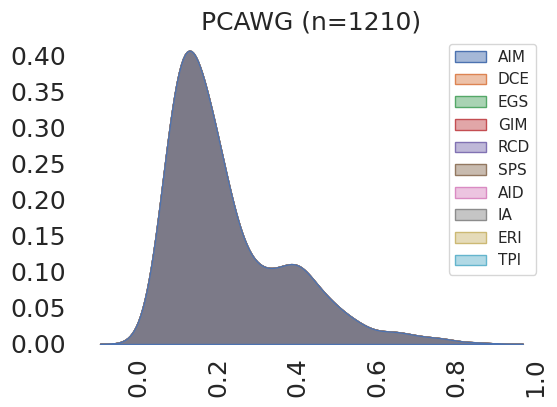

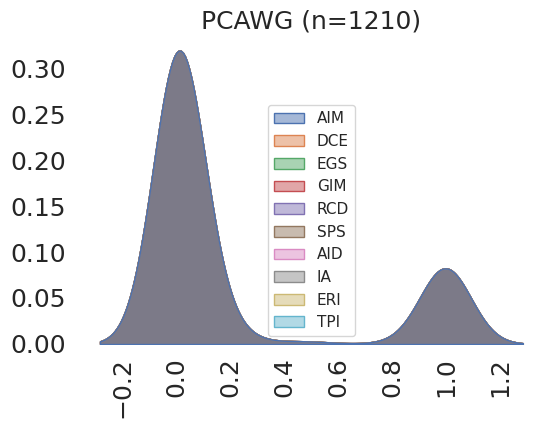

['pcawg_output_dfs.pkl']

In [99]:
pcawg1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
pcawg1_output_dfs = {}

for model_type in pcawg1_model_types:
    prob_df = pd.DataFrame(index=pcawg1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(pcawg1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "PCAWG (n=1210)", "PCAWG", model_type)
    pcawg1_output_dfs[model_type] = prob_df
    
joblib.dump(pcawg1_output_dfs, 'pcawg_output_dfs.pkl')

# Model Specificity (true negative rate) check on normal ENCODE tissue datasets

In [100]:
folder_path = '/data1/Projects/Hallmark/val_data/ENCODE'
encode_list = []
for file in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, file), sep='\t', index_col=0)
    df = df[['TPM']]
    df = df[df.index.str.startswith("ENSG")]
    df.index = df.index.str.split('.').str[0]
    df = df.groupby(df.index).sum()
    df.columns = [file.split('.')[0]]
    encode_list.append(df)

In [101]:
encode_meta = pd.read_csv('encode_metadata.tsv', sep='\t')
encode_meta = encode_meta[encode_meta['Output type'] == 'gene quantifications']
encode_meta

,File accession,File format,File type,File format type,Output type,File assembly,Experiment accession,Assay,Donor(s),Biosample term id,...,Platform,Controlled by,File Status,s3_uri,Azure URL,File analysis title,File analysis status,Audit WARNING,Audit NOT_COMPLIANT,Audit ERROR
2,ENCFF042XFA,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR634JQK,total RNA-seq,/human-donors/ENCDO242JQO/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/03/09/9f63949f-8eb9-43...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
5,ENCFF770BLB,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR920OZR,total RNA-seq,/human-donors/ENCDO607PIC/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/05/13/875e7d1a-e112-4e...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
8,ENCFF614VLQ,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR922XPO,total RNA-seq,/human-donors/ENCDO287LNQ/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/04/14/449576e5-b622-4e...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
11,ENCFF687GJE,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR394HJK,total RNA-seq,/human-donors/ENCDO736YJH/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/05/13/994132d6-d0c1-45...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
13,ENCFF258ANV,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR394ZSF,total RNA-seq,/human-donors/ENCDO203ASI/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/03/09/1523e8b8-4c7e-4d...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,ENCFF993FDD,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR763OMY,total RNA-seq,/human-donors/ENCDO575WHY/,UBERON:0002369,...,NaN,NaN,released,s3://encode-public/2020/11/03/76db360d-73b7-48...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.1 GRCh38 V29,released,NaN,NaN,NaN
976,ENCFF574KNI,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR985WSV,total RNA-seq,/human-donors/ENCDO461DJY/,UBERON:0009834,...,NaN,NaN,released,s3://encode-public/2022/05/13/8382bb3c-bd39-49...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.3 GRCh38 V29,released,NaN,NaN,NaN
978,ENCFF939MHB,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR313COD,total RNA-seq,/human-donors/ENCDO845WKR/,UBERON:0008952,...,NaN,NaN,released,s3://encode-public/2020/07/14/e8026bec-98aa-47...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.1.0 GRCh38 V29,released,NaN,NaN,NaN
981,ENCFF004TUO,tsv,tsv,NaN,gene quantifications,GRCh38,ENCSR165QTZ,total RNA-seq,/human-donors/ENCDO186XRB/,UBERON:0001264,...,NaN,NaN,released,s3://encode-public/2020/11/03/789d5072-e36a-4f...,https://datasetencode.blob.core.windows.net/da...,ENCODE4 v1.2.1 GRCh38 V29,released,NaN,NaN,NaN


In [102]:
encode = pd.concat(encode_list, axis=1)
encode = encode[encode_meta['File accession']]
encode_gene = ensembl_to_hugo(encode.index).set_index('ENSEMBL_ID')
encode_gene = encode_gene[['HGNC_ID']]
encode = pd.concat([encode_gene, encode], axis=1).dropna(subset=['HGNC_ID']).set_index('HGNC_ID').fillna(0)
encode

,ENCFF042XFA,ENCFF770BLB,ENCFF614VLQ,ENCFF687GJE,ENCFF258ANV,ENCFF823FJI,ENCFF787TLF,ENCFF899PWS,ENCFF870FXA,ENCFF846SOK,...,ENCFF530KIE,ENCFF677FGG,ENCFF759RCN,ENCFF096SPQ,ENCFF612UEF,ENCFF993FDD,ENCFF574KNI,ENCFF939MHB,ENCFF004TUO,ENCFF632UQN
HGNC_ID,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0.00,0.06,0.00,0.00,0.00,0.00,0.05,0.00,0.19,0.00,...,0.12,0.23,0.00,0.00,0.04,0.00,0.09,0.00,0.00,0.00
WASH7P,2.74,3.75,7.87,8.00,4.89,6.07,7.41,2.58,7.11,0.88,...,1.99,5.00,3.48,2.79,2.17,3.90,4.57,1.16,2.19,0.48
MIR1302-11,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00
FAM138A,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.59,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00
OR4G4P,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WI2-2610K16.1,0.06,0.00,0.05,0.03,0.01,0.01,0.02,0.04,0.03,0.01,...,0.01,0.01,0.16,0.00,0.00,0.02,0.04,0.22,0.16,0.50
WI2-2942J8.1,0.08,0.13,0.05,0.10,0.09,0.15,0.12,0.10,0.14,0.00,...,0.00,0.20,0.02,0.00,0.03,0.01,0.14,0.00,0.01,0.00
XX-CR54.3,2.68,1.18,3.52,3.28,3.15,3.06,1.12,5.49,2.98,0.01,...,0.00,1.57,0.02,0.00,0.00,0.00,4.80,0.00,0.03,0.00


In [103]:
encode1 = encode.T
encode1 = encode1.loc[:, ~encode1.columns.duplicated(keep='first')]
encode1 = encode1.reindex(columns = feature_name, fill_value = 0).fillna(0)
encode1_index = encode1.index
encode1_columns = encode1.columns
encode1 = rankdata(encode1 * -1, axis=1, method='average')
encode1 = pd.DataFrame(np.log2(encode1))
encode1.index = encode1_index
encode1.columns = encode1_columns
encode1

HGNC_ID,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,...,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
ENCFF042XFA,12.943522,12.496604,12.689889,12.858855,12.417457,11.255029,11.312883,12.949918,8.768184,12.993911,...,4.321928,11.806751,11.120238,12.271609,11.193833,12.883025,10.501837,12.758744,12.127511,13.052653
ENCFF770BLB,12.916812,12.792485,12.826946,12.621365,12.687704,11.711452,12.076983,12.637304,9.276124,12.944255,...,4.392317,11.400613,11.079151,12.259302,10.754052,12.842154,10.459944,12.745359,11.781565,13.059175
ENCFF614VLQ,12.955650,12.481673,12.724620,12.780642,12.535761,11.516931,11.186733,12.960726,9.047124,13.027733,...,4.459432,11.760096,11.266787,12.015241,11.584728,12.817983,10.873829,12.807657,11.801102,13.125736
ENCFF687GJE,12.967947,12.540612,12.787392,12.752590,12.337901,11.244661,11.630722,12.951103,8.818582,12.989306,...,4.169925,11.814783,10.932215,12.029460,11.787086,12.851944,10.330917,12.662557,11.930183,13.129203
ENCFF258ANV,12.984240,12.616204,12.731637,12.775507,12.549544,11.082482,11.383704,12.969746,8.562242,12.941139,...,4.321928,12.198599,11.345405,11.772108,11.769838,12.839007,10.883407,12.758640,11.489848,13.065248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENCFF993FDD,13.006414,11.837037,10.714246,12.788922,12.712097,10.482304,12.003869,12.523562,8.554589,12.753008,...,2.321928,12.307058,11.980140,11.749031,10.026523,12.122504,11.401946,12.539522,10.436712,13.077734
ENCFF574KNI,12.870461,12.414553,12.798371,12.831505,12.377753,11.257977,11.015415,12.921283,8.936638,12.944071,...,4.459432,11.924998,11.408860,12.123475,11.859146,12.799180,10.981210,12.708976,11.965063,13.052143
ENCFF939MHB,12.841761,12.643631,12.003167,12.179754,12.800091,10.649705,12.568550,12.988063,10.398744,12.856231,...,3.321928,12.652621,11.544723,11.293472,11.799889,12.406736,11.355626,12.022888,11.772108,11.109831
ENCFF004TUO,12.922213,12.626165,12.421144,12.818682,12.542306,10.687813,12.149906,13.000528,9.359750,12.984329,...,1.584963,12.217200,11.446566,11.721954,11.701090,12.501215,11.187043,12.043711,9.695228,12.959187


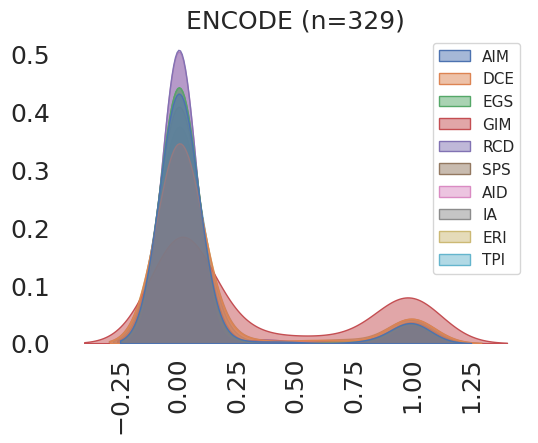

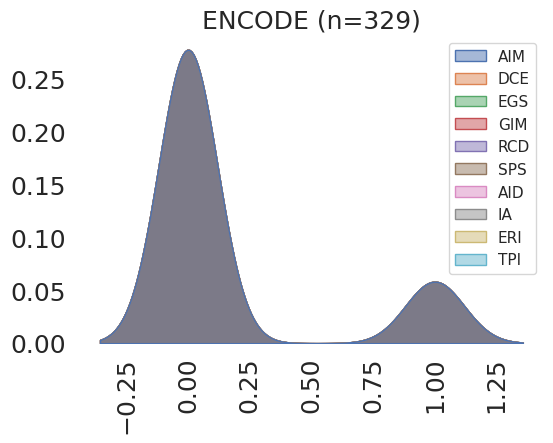

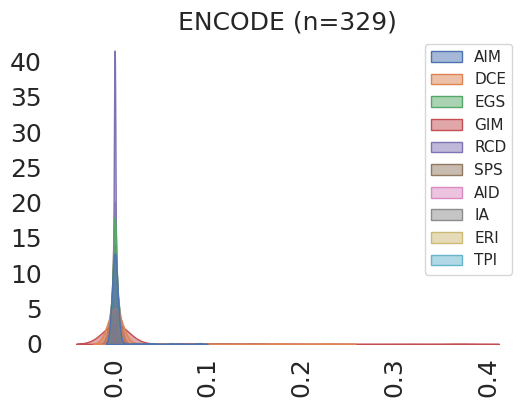

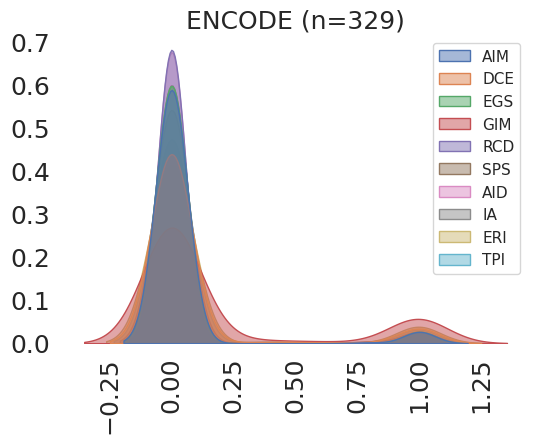

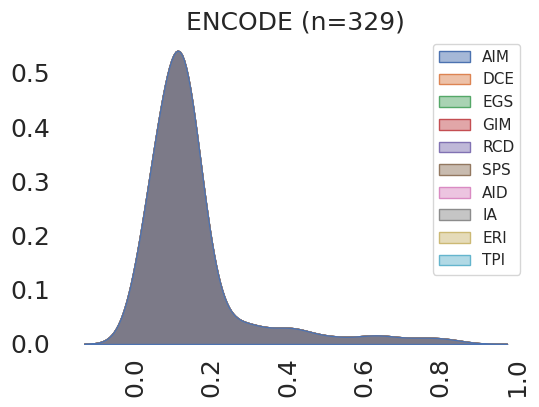

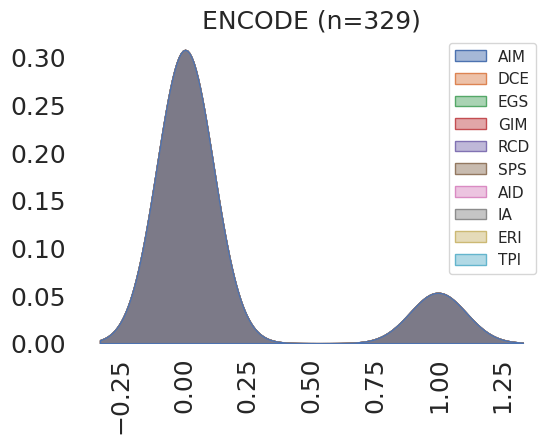

['encode_output_dfs.pkl']

In [104]:
encode1_model_types = list(models_per_hallmark[next(iter(models_per_hallmark))].keys())
encode1_output_dfs = {}

for model_type in encode1_model_types:
    prob_df = pd.DataFrame(index=encode1_index)
    for hallmark in hall_list:
        model = models_per_hallmark[hallmark][model_type]
        classifier = model.named_steps['model']
        prob = model.predict_proba(encode1)[:, 1]
        prob_df[hallmark] = prob

    plot_kde(prob_df, "ENCODE (n=329)", "ENCODE", model_type)
    encode1_output_dfs[model_type] = prob_df
    
joblib.dump(encode1_output_dfs, 'encode_output_dfs.pkl')